#  Predicción de precios en el mercado de autos usados a partir de características

En el mercado de automóviles de segunda mano, determinar el valor exacto de un vehículo es un desafío debido a la gran cantidad de variables que influyen en su precio. Tanto compradores como vendedores enfrentan la incertidumbre de establecer un valor justo, lo que a menudo resulta en transacciones que no reflejan el verdadero valor del auto. Esto puede conducir a pérdidas significativas, ya sea por pagar de más o recibir menos de lo que el vehículo realmente vale. Tradicionalmente, el precio se ha calculado en función de la intuición o el conocimiento personal sobre autos, métodos que, aunque útiles, carecen de precisión y pueden fallar.
Para mejorar la precisión en la valoración de automóviles usados, hemos desarrollado un sistema basado en técnicas avanzadas de data science y machine learning. Este sistema organiza y analiza una base de datos exhaustiva de vehículos, permitiendo realizar comparaciones detalladas entre diferentes opciones. Al emplear modelos de machine learning, podemos identificar patrones complejos y hacer predicciones precisas, tomando en cuenta una variedad de factores críticos que influyen en el precio del auto. Estos factores incluyen el tiempo de uso, el estado de las distintas piezas, el historial de mantenimiento, la demanda del modelo en el mercado, y las fluctuaciones en los precios a lo largo del tiempo.
Gracias a este enfoque, logramos una predicción de precios significativamente más precisa, superando las estimaciones basadas únicamente en la intuición. Este sistema no solo aporta mayor confianza a compradores y vendedores, sino que también optimiza el proceso de compra-venta, ahorrando tiempo y minimizando riesgos financieros.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime

In [2]:
df = pd.read_csv("../data/car_data.csv", delimiter=",")
print(len(df))
df.head()

3707


,brand,model,version,price,kilometraje,cylinder,city,region,year,fuel_type,transmission,doors,plate,description,only_owner,never_bumped,checked_maintenance,state
0,VOLKSWAGEN,ESCARABAJO,"1,6 LTS. SEDÁN 2P. T/M MOTOR ACD",12000000,4427,1.6,Vitacura,13,1996,gasolina,mecanico,2.0,NZ5309,"Este ejemplar fue adquirido en el 2020, siendo...",NaN,True,NaN,1
1,AUDI,Q2,35 TFSI,27990000,14800,1.4,Las Condes,13,2023,gasolina,automatico,4.0,SPGK33,Dos llaves\r\n\r\n– Caja automática S-Tronic d...,True,True,True,1
2,SUBARU,FORESTER,NaN,5290000,249890,NaN,Rancagua,6,2008,NaN,NaN,NaN,BFSW85,NaN,NaN,NaN,NaN,1
3,JEEP,GRAND CHEROKEE,NaN,20590000,106000,NaN,Las Condes,13,2018,NaN,NaN,NaN,PRZL35,NaN,NaN,NaN,NaN,1
4,M. BENZ,GLA,200,20500000,57200,1.6,Los Ángeles,8,2019,gasolina,automatico,4.0,LFBC27,Mercedes Benz Gla200 1.6 Neumáticos delanteros...,NaN,NaN,NaN,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3707 entries, 0 to 3706
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   brand                3707 non-null   object 
 1   model                3707 non-null   object 
 2   version              783 non-null    object 
 3   price                3707 non-null   int64  
 4   kilometraje          3707 non-null   int64  
 5   cylinder             1216 non-null   float64
 6   city                 3707 non-null   object 
 7   region               3707 non-null   int64  
 8   year                 3707 non-null   int64  
 9   fuel_type            1298 non-null   object 
 10  transmission         1287 non-null   object 
 11  doors                1253 non-null   float64
 12  plate                3707 non-null   object 
 13  description          1522 non-null   object 
 14  only_owner           472 non-null    object 
 15  never_bumped         600 non-null    o

In [4]:
df.isnull().sum()

brand                     0
model                     0
version                2924
price                     0
kilometraje               0
cylinder               2491
city                      0
region                    0
year                      0
fuel_type              2409
transmission           2420
doors                  2454
plate                     0
description            2185
only_owner             3235
never_bumped           3107
checked_maintenance    3437
state                     0
dtype: int64

In [5]:
df = df.drop(columns=["doors", "plate", "description", "only_owner", "never_bumped", "checked_maintenance", "state", "version", "city"])

In [6]:
df.isna().sum()

brand              0
model              0
price              0
kilometraje        0
cylinder        2491
region             0
year               0
fuel_type       2409
transmission    2420
dtype: int64

In [7]:
df.dropna(subset=["cylinder", "fuel_type", "transmission"], how="all", inplace=True)

In [8]:
df.isna().sum()

brand            0
model            0
price            0
kilometraje      0
cylinder        94
region           0
year             0
fuel_type       12
transmission    23
dtype: int64

In [9]:
df["price"] = pd.to_numeric(df.price) / 1_000_000

# Diccionario que mapea el número de la región a su nombre
region_mapping = {
    1: 'Tarapacá',
    2: 'Antofagasta',
    3: 'Atacama',
    4: 'Coquimbo',
    5: 'Valparaíso',
    6: 'O’Higgins',
    7: 'Maule',
    8: 'Biobío',
    9: 'La Araucanía',
    10: 'Los Lagos',
    11: 'Aysén',
    12: 'Magallanes',
    13: 'Metropolitana',
    14: 'Los Ríos',
    15: 'Arica y Parinacota',
    16: 'Ñuble'
}
df['region'] = df['region'].map(region_mapping)

col_names = {"price": "precio", "year": "año", "cylinder": "motor", "kilometers": "kilometraje", "fuel_type": "combustible", "transmission": "transmision", "region": "region", "model": "modelo", "brand": "marca"}

df.rename(columns=col_names, inplace=True)

In [10]:
df.describe()

,precio,kilometraje,motor,año
count,1310.000000,1310.000000,1216.000000,1310.000000
mean,18.002540,83270.649618,2.248602,2017.806870
std,12.825903,57131.573661,0.915211,4.351632
min,0.750000,111.000000,1.000000,1980.000000
25%,9.892500,37512.000000,1.600000,2015.000000
50%,13.990000,77000.000000,2.000000,2019.000000
75%,21.990000,117000.000000,2.500000,2021.000000
max,117.990000,384005.000000,6.200000,2024.000000


## Análisis de datos exploratorio

In [11]:
sns.set_context("paper")

In [12]:
df_eda = df.copy()
df_eda

,marca,modelo,precio,kilometraje,motor,region,año,combustible,transmision
0,VOLKSWAGEN,ESCARABAJO,12.00,4427,1.6,Metropolitana,1996,gasolina,mecanico
1,AUDI,Q2,27.99,14800,1.4,Metropolitana,2023,gasolina,automatico
4,M. BENZ,GLA,20.50,57200,1.6,Biobío,2019,gasolina,automatico
7,DS,DS3,19.95,21742,1.2,Metropolitana,2022,gasolina,automatico
13,M. BENZ,G,74.99,94000,5.5,Metropolitana,2012,gasolina,automatico
...,...,...,...,...,...,...,...,...,...
3695,FORD,TERRITORY,15.19,26500,1.5,Metropolitana,2022,gasolina,automatico
3697,CITROEN,C5,24.99,18000,1.5,Metropolitana,2023,diesel,automatico
3698,M. BENZ,A250,25.00,44000,NaN,Antofagasta,2019,gasolina,automatico
3699,SUZUKI,DZIRE,8.00,24000,1.2,Metropolitana,2019,gasolina,mecanico


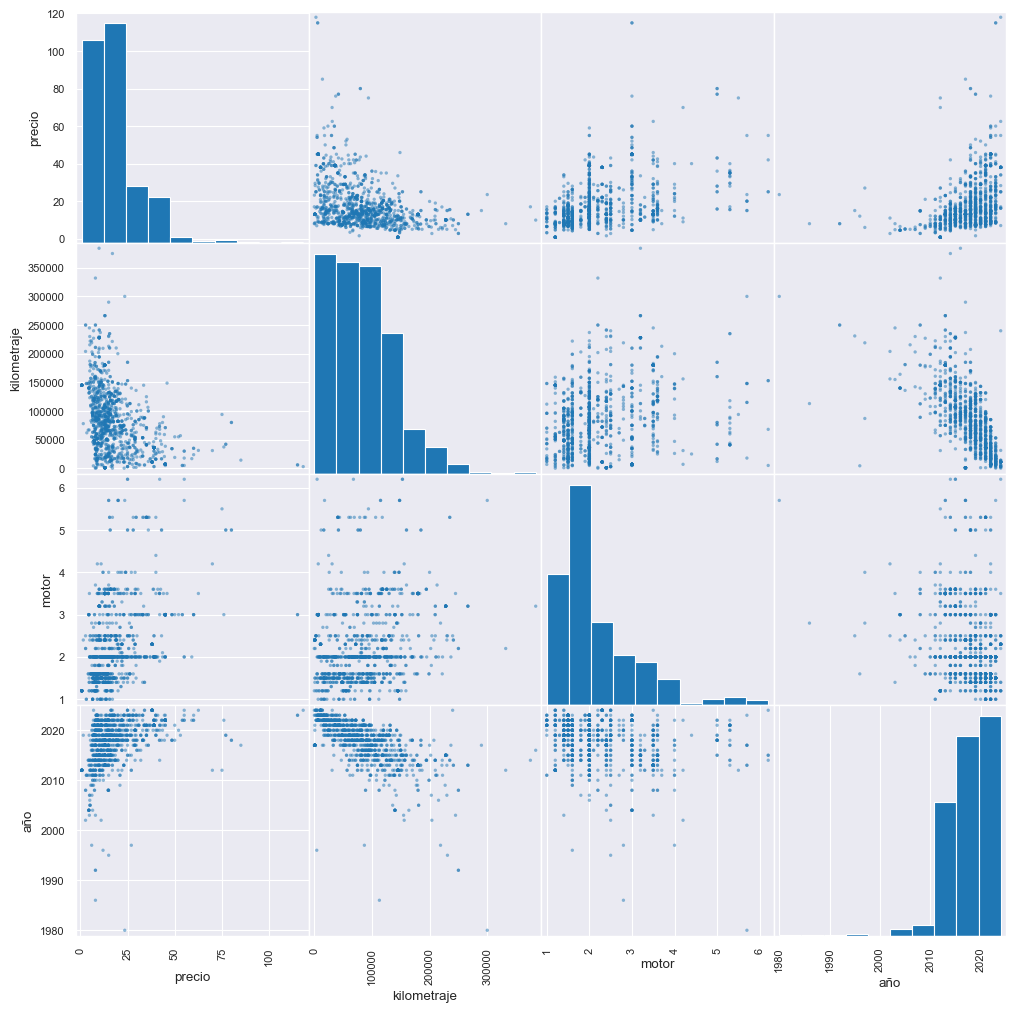

In [13]:
from pandas.plotting import scatter_matrix

scatter_matrix(df_eda[["precio", "kilometraje", "motor", "año"]], figsize=(12, 12))
plt.show()

### Precio

In [14]:
df_eda.precio.describe()


count    1310.000000
mean       18.002540
std        12.825903
min         0.750000
25%         9.892500
50%        13.990000
75%        21.990000
max       117.990000
Name: precio, dtype: float64

In [15]:
df_eda = df_eda[(df_eda.precio<100) & (df_eda.año>=2000) & (df_eda.combustible!="otro")]

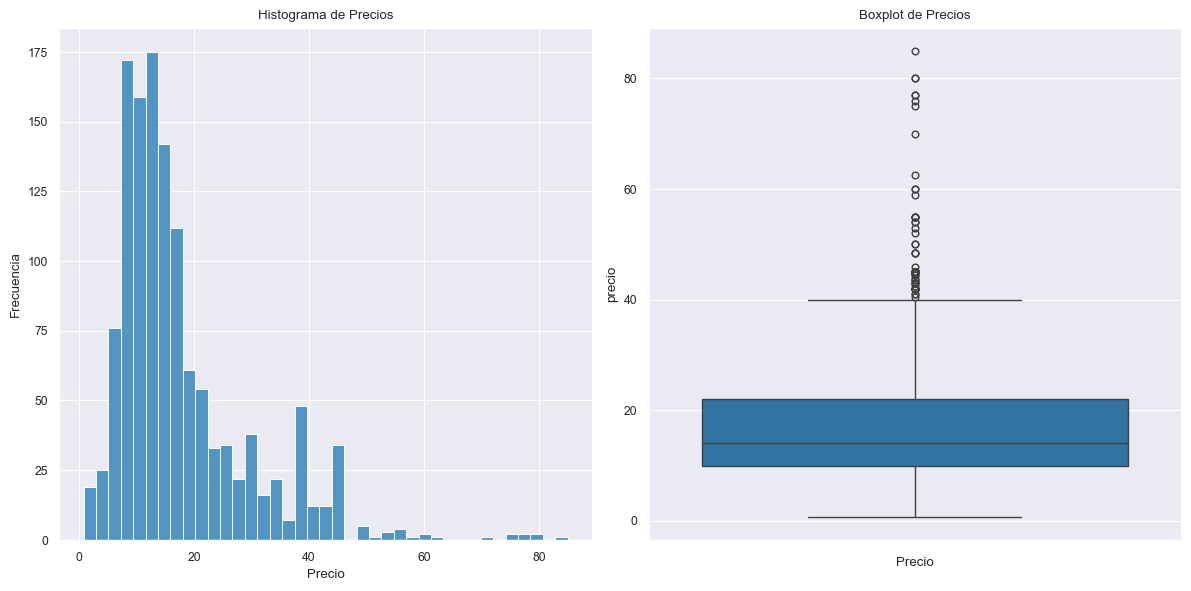

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Histograma a la izquierda
sns.histplot(df_eda['precio'], kde=False, ax=axes[0])
axes[0].set_title('Histograma de Precios')
axes[0].set_xlabel('Precio')
axes[0].set_ylabel('Frecuencia')

# Diagrama de caja (boxplot) a la derecha
sns.boxplot(y=df_eda['precio'], ax=axes[1])
axes[1].set_title('Boxplot de Precios')
axes[1].set_xlabel('Precio')

# Mostrar los gráficos
plt.tight_layout()
plt.show()


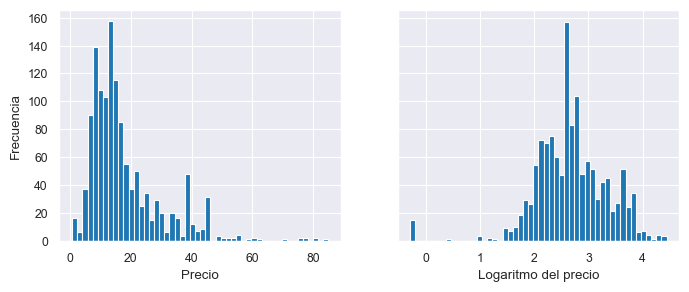

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
df_eda['precio'].hist(ax=axs[0], bins=50)
df_eda['precio'].apply(np.log).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("Precio")
axs[1].set_xlabel("Logaritmo del precio")
axs[0].set_ylabel("Frecuencia")
plt.show()



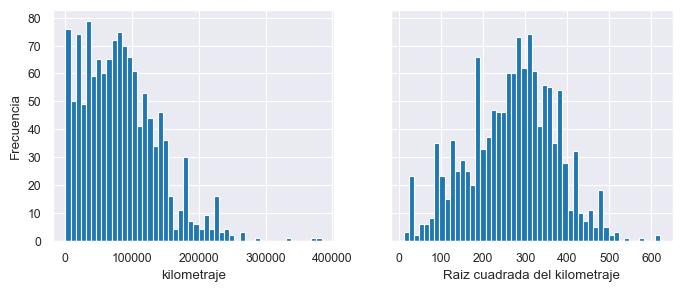

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
df_eda['kilometraje'].hist(ax=axs[0], bins=50)
df_eda['kilometraje'].apply(np.sqrt).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("kilometraje")
axs[1].set_xlabel("Raiz cuadrada del kilometraje")
axs[0].set_ylabel("Frecuencia")
plt.show()


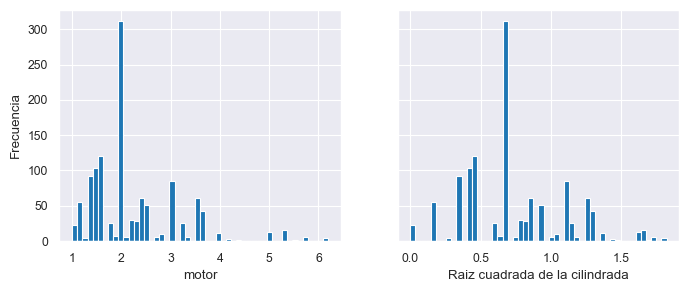

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
df_eda['motor'].hist(ax=axs[0], bins=50)
df_eda['motor'].apply(np.log).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("motor")
axs[1].set_xlabel("Raiz cuadrada de la cilindrada")
axs[0].set_ylabel("Frecuencia")
plt.show()

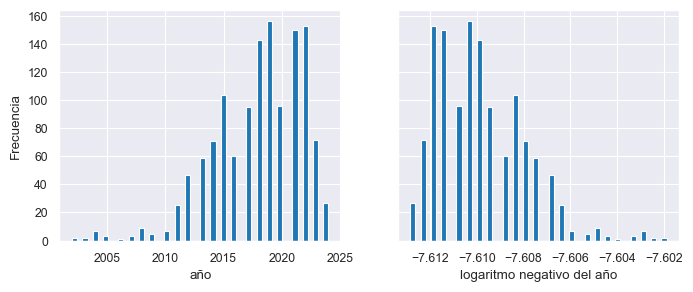

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
df_eda['año'].hist(ax=axs[0], bins=50)
df_eda['año'].apply(lambda x: -np.log(x)).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("año")
axs[1].set_xlabel("logaritmo negativo del año")
axs[0].set_ylabel("Frecuencia")
plt.show()

### Relación entre kilometraje y precio

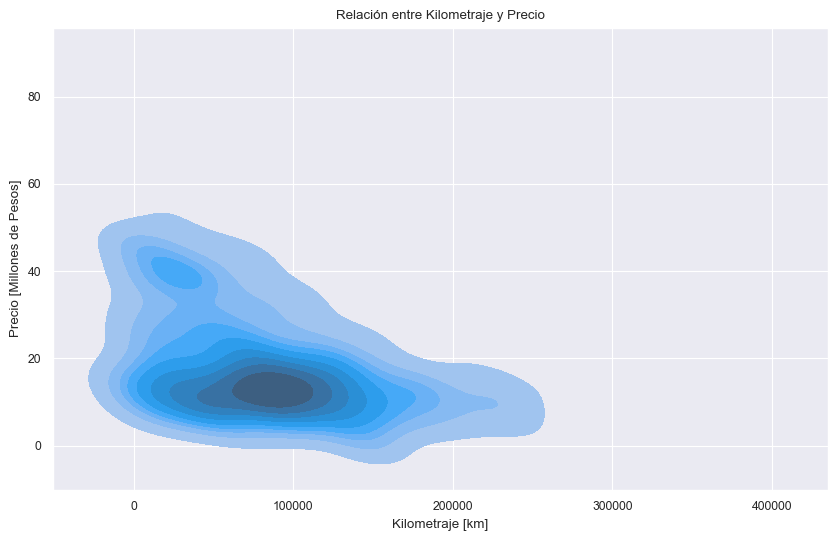

In [21]:
plt.figure(figsize=(10, 6))
sns.kdeplot(x='kilometraje', y='precio', data=df_eda, fill=True)
plt.title('Relación entre Kilometraje y Precio')
plt.xlabel('Kilometraje [km]')
plt.ylabel('Precio [Millones de Pesos]')
plt.show()


### Relación entre tipo de combustible y precio

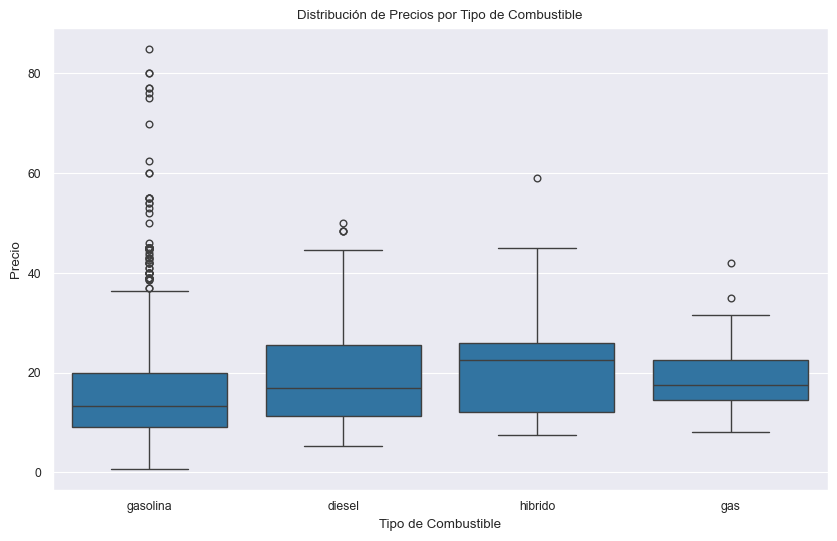

In [22]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='combustible', y='precio', data=df_eda)
plt.title('Distribución de Precios por Tipo de Combustible')
plt.xlabel('Tipo de Combustible')
plt.ylabel('Precio')
plt.show()


### Relación entre tipo de transmición y precio

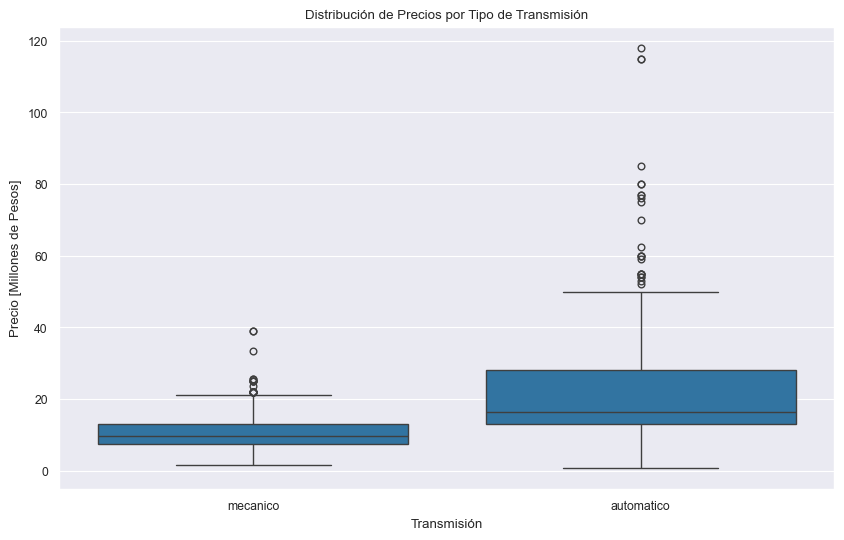

In [23]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='transmision', y='precio', data=df)
plt.title('Distribución de Precios por Tipo de Transmisión')
plt.xlabel('Transmisión')
plt.ylabel('Precio [Millones de Pesos]')
plt.show()


### Relación entre Año y precio

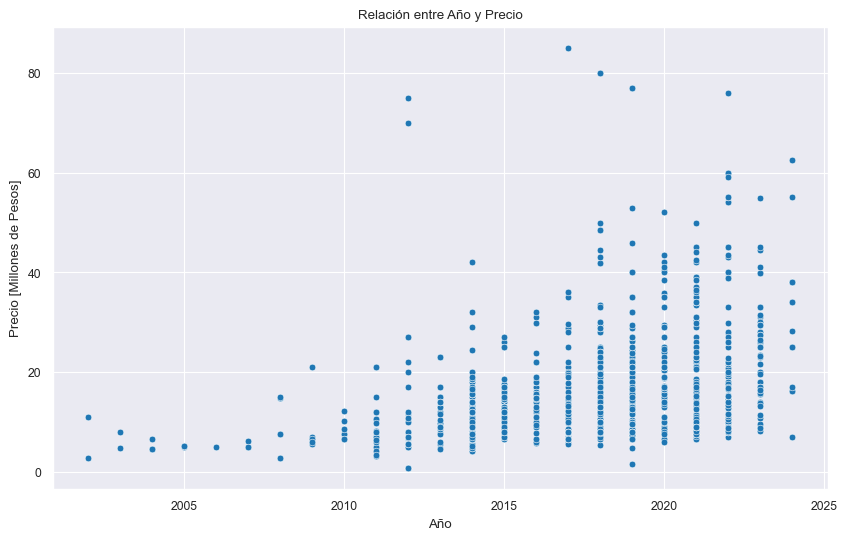

In [24]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='año', y='precio', data=df_eda)
plt.title('Relación entre Año y Precio')
plt.xlabel('Año')
plt.ylabel('Precio [Millones de Pesos]')
plt.show()

### Relación entre tamaño motor y precio

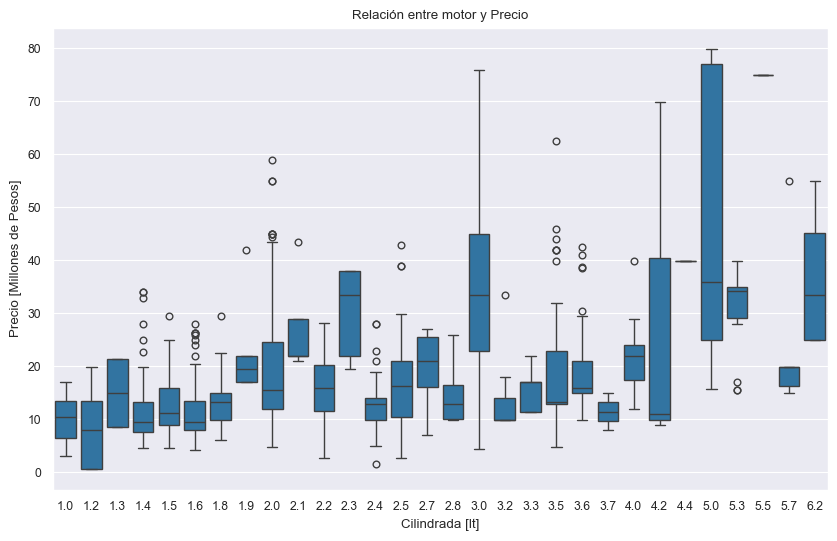

In [25]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='motor', y='precio', data=df_eda)
plt.title('Relación entre motor y Precio')
plt.xlabel('Cilindrada [lt]')
plt.ylabel('Precio [Millones de Pesos]')
plt.show()

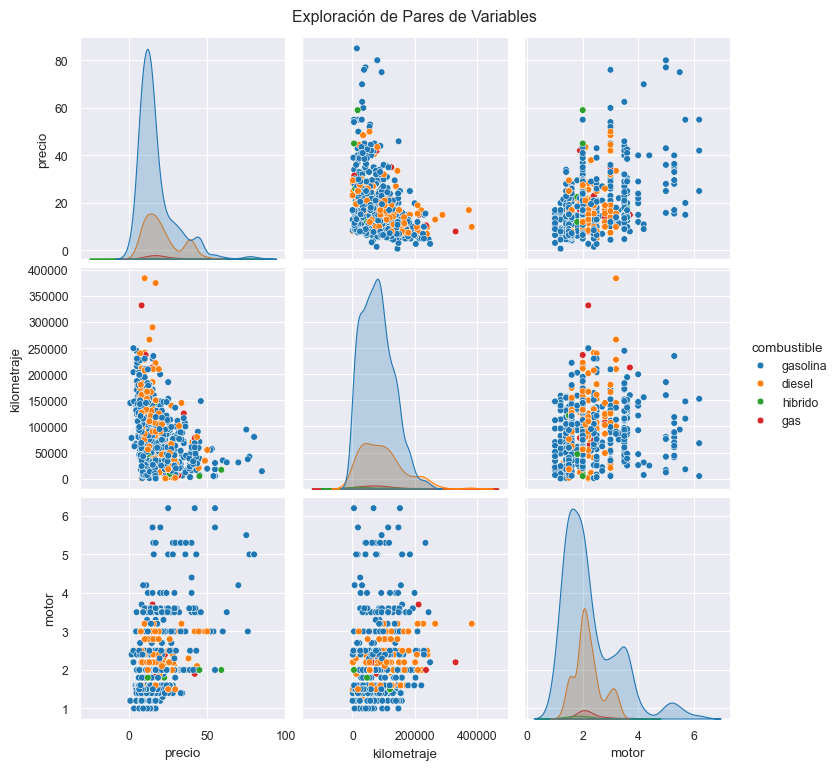

In [26]:
sns.pairplot(df_eda, vars=['precio', 'kilometraje', 'motor'], hue='combustible')
plt.suptitle('Exploración de Pares de Variables', y=1.02)
plt.show()


### Kilometraje por año

In [27]:
# Obtener el año actual
year_current = datetime.now().year

# Crear la columna de cantidad de años del auto
df_eda['años_auto'] = year_current - df_eda['año']

# Crear la columna de kilometraje por año
df_eda['kilometraje_por_año'] = df_eda['kilometraje'] / df_eda['años_auto']

df_eda

C:\Users\Timining\AppData\Local\Temp\ipykernel_31708\1039137158.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eda['años_auto'] = year_current - df_eda['año']
C:\Users\Timining\AppData\Local\Temp\ipykernel_31708\1039137158.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eda['kilometraje_por_año'] = df_eda['kilometraje'] / df_eda['años_auto']


,marca,modelo,precio,kilometraje,motor,region,año,combustible,transmision,años_auto,kilometraje_por_año
1,AUDI,Q2,27.99,14800,1.4,Metropolitana,2023,gasolina,automatico,1,14800.000000
4,M. BENZ,GLA,20.50,57200,1.6,Biobío,2019,gasolina,automatico,5,11440.000000
7,DS,DS3,19.95,21742,1.2,Metropolitana,2022,gasolina,automatico,2,10871.000000
13,M. BENZ,G,74.99,94000,5.5,Metropolitana,2012,gasolina,automatico,12,7833.333333
17,SKODA,FABIA,10.89,43000,1.0,Metropolitana,2021,gasolina,mecanico,3,14333.333333
...,...,...,...,...,...,...,...,...,...,...,...
3695,FORD,TERRITORY,15.19,26500,1.5,Metropolitana,2022,gasolina,automatico,2,13250.000000
3697,CITROEN,C5,24.99,18000,1.5,Metropolitana,2023,diesel,automatico,1,18000.000000
3698,M. BENZ,A250,25.00,44000,NaN,Antofagasta,2019,gasolina,automatico,5,8800.000000
3699,SUZUKI,DZIRE,8.00,24000,1.2,Metropolitana,2019,gasolina,mecanico,5,4800.000000


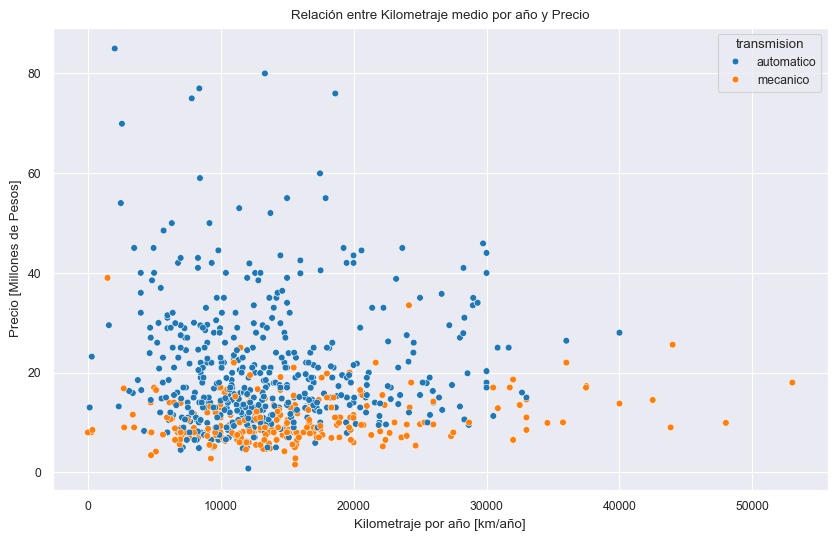

In [28]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='kilometraje_por_año', y='precio', data=df_eda, hue="transmision")
plt.title('Relación entre Kilometraje medio por año y Precio')
plt.xlabel('Kilometraje por año [km/año]')
plt.ylabel('Precio [Millones de Pesos]')
plt.show()

### Matriz de correlación

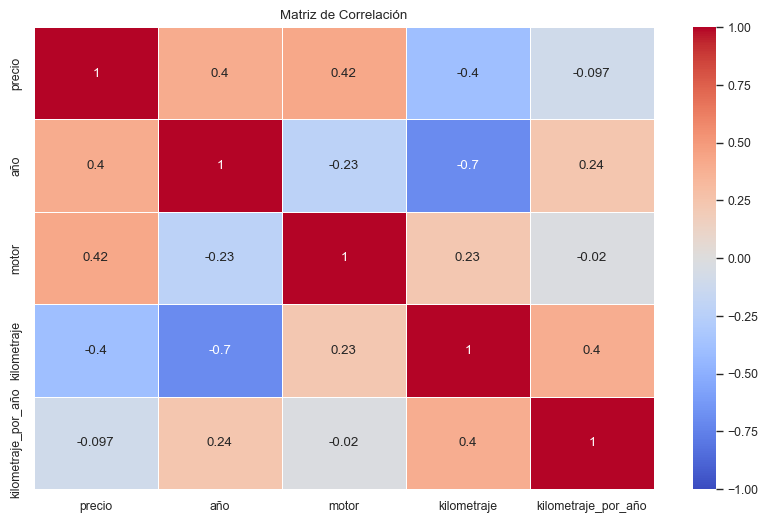

In [29]:
plt.figure(figsize=(10, 6))
correlation_matrix = df_eda[["precio", "año", "motor", "kilometraje", "kilometraje_por_año"]].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, vmin=-1)
plt.title('Matriz de Correlación')
plt.show()


#### Matriz de correlacion por modelo

In [30]:
df_clean = df.copy()
df_clean = df_clean[(df.precio<100) & (df.año>=2000) & (df.combustible!="otro")]

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_clean[["marca", "modelo", "motor", "combustible", "kilometraje", "transmision", "region", "año"]], df_clean.precio, test_size=0.3, random_state=42) 

In [32]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_val_score

num_attribs = ["motor", "kilometraje", "año"]
cat_attribs = ["marca", "modelo", "combustible", "transmision", "region"]

def neg_log(x):
    return -np.log1p(x)

def inverse_neg_log(x):
    return np.expm1(-x)

# Definir transformaciones personalizadas con sus funciones inversas
sqrt_transformer = FunctionTransformer(np.sqrt, inverse_func=np.square, validate=True)
log_transformer = FunctionTransformer(np.log1p, inverse_func=np.expm1, validate=True)
neg_log_transformer = FunctionTransformer(neg_log, inverse_func=inverse_neg_log, validate=True)

# Pipeline para "kilometraje" (transformación raíz cuadrada + escalado)
kilometraje_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    sqrt_transformer,
)

# Pipeline para "motor" (transformación logarítmica + escalado)
motor_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    log_transformer,
)

# Pipeline para "año" (transformación logaritmo negativo + escalado)
año_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    neg_log_transformer,
)

kilometraje_pipeline_scaled = make_pipeline(
    SimpleImputer(strategy="median"),
    sqrt_transformer,
    StandardScaler()
)

# Pipeline para "motor" (transformación logarítmica + escalado)
motor_pipeline_scaled = make_pipeline(
    SimpleImputer(strategy="median"),
    log_transformer,
    StandardScaler()
)

# Pipeline para "año" (transformación logaritmo negativo + escalado)
año_pipeline_scaled = make_pipeline(
    SimpleImputer(strategy="median"),
    neg_log_transformer,
    StandardScaler()
)

# Pipeline para atributos categóricos
cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"),
)

preprocessing = make_column_transformer(
    (kilometraje_pipeline, ["kilometraje"]),
    (motor_pipeline, ["motor"]),
    (año_pipeline, ["año"]),
    (cat_pipeline, cat_attribs)
)

# Preprocesamiento con transformaciones específicas para columnas numéricas + escalado
preprocessing_scaled = make_column_transformer(
    (kilometraje_pipeline_scaled, ["kilometraje"]),
    (motor_pipeline_scaled, ["motor"]),
    (año_pipeline_scaled, ["año"]),
    (cat_pipeline, cat_attribs)
)


In [33]:
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.compose import TransformedTargetRegressor

def plot_predicted_vs_measured(estimator, X, y, cv=None, alpha=0.5):
    predicted = cross_val_predict(estimator, X, y, cv=cv)
    print(f"RMSE = {root_mean_squared_error(y, predicted):.3f}")
    fig, ax = plt.subplots()
    ax.scatter(y, predicted, alpha=alpha)
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    plt.title(str(estimator.__class__).replace("'>", '').split('.')[-1])
    plt.show()
    
def display_validation_scores(estimator, X, y, cv=10):
    scores = np.sqrt(-cross_val_score(estimator, X, y, scoring="neg_mean_squared_error", cv=cv))
    print("Scores:", scores)
    print(f"Mean: {scores.mean():.3}")
    print(f"Standar deviation: {scores.std():.3}")

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

lin_reg = make_pipeline(preprocessing, PolynomialFeatures(), LinearRegression())
lin_reg.set_params(polynomialfeatures__degree=1, polynomialfeatures__include_bias=False)
lin_reg.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(func=<ufunc 'sqrt'>,
                                                                                       inverse_func=<ufunc 'square'>,
                                                                                       validate=True))]),
                                                  ['kilometraje']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='med...
                                                                                       inverse_func=<function inverse_neg_log at 0x000001F44CC49900>,
                                                                                       validate=True))]),
                                                  ['año']),
                                                 ('pipeline-4',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['marca', 'modelo',
                                                   'combustible', 'transmision',
                                                   'region'])])),
                ('polynomialfeatures',
                 PolynomialFeatures(degree=1, include_bias=False)),
                ('linearregression', LinearRegression())])

In [35]:
print(f"RMSE = {root_mean_squared_error(y_train, lin_reg.predict(X_train)):.3f}")

RMSE = 3.141


RMSE = 6.257


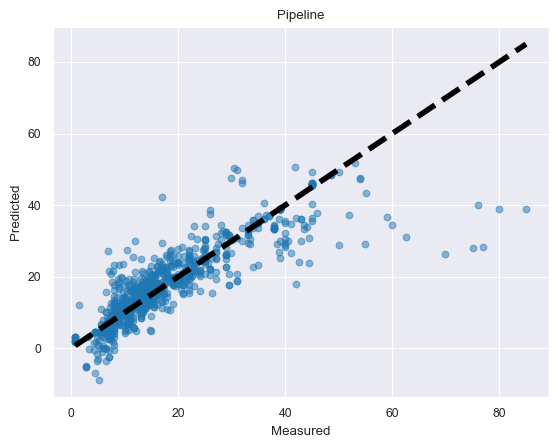

In [36]:
plot_predicted_vs_measured(lin_reg, X_train, y_train, cv=6)

In [37]:
params_lr = [{"polynomialfeatures__degree": range(1,4)}]
lr_search = GridSearchCV(lin_reg, params_lr, scoring="neg_mean_squared_error", n_jobs=-1, verbose=2).fit(X_train, y_train)
lr_results = pd.DataFrame(lr_search.cv_results_).sort_values("rank_test_score", ascending=True).head()
lr_results["mean_test_score"] = np.sqrt(-lr_results["mean_test_score"])
best_lr = lr_search.best_estimator_
display(lr_results)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_polynomialfeatures__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.083016,0.009964,0.019712,0.002283,1,{'polynomialfeatures__degree': 1},-50.222479,-49.386245,-42.502118,-36.976859,-20.803112,6.322829,10.737959,1
1,1.053913,0.240634,0.029306,0.011458,2,{'polynomialfeatures__degree': 2},-63.373078,-354.018246,-86.235869,-120.955807,-26.900936,11.414762,115.973613,2
2,143.979293,2.343478,0.013502,0.003496,3,{'polynomialfeatures__degree': 3},-159.573163,-2397.345764,-92.096480,-527.161834,-100.095143,25.597939,885.701819,3


In [38]:
from sklearn.linear_model import ElasticNetCV

elastic_net = make_pipeline(preprocessing_scaled, ElasticNetCV(cv=5))
elastic_net.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(func=<ufunc 'sqrt'>,
                                                                                       inverse_func=<ufunc 'square'>,
                                                                                       validate=True)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['kilometraje']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simple...
                                                                                       inverse_func=<function inverse_neg_log at 0x000001F44CC49900>,
                                                                                       validate=True)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['año']),
                                                 ('pipeline-4',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['marca', 'modelo',
                                                   'combustible', 'transmision',
                                                   'region'])])),
                ('elasticnetcv', ElasticNetCV(cv=5))])

In [39]:
print(f"RMSE = {root_mean_squared_error(y_train, elastic_net.predict(X_train)):.3f}")

RMSE = 5.172


RMSE = 6.197


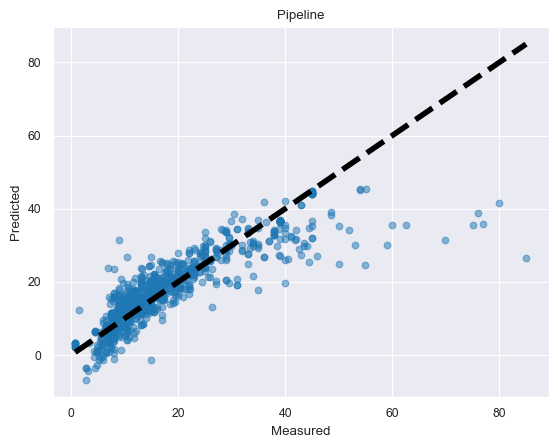

In [40]:
plot_predicted_vs_measured(elastic_net, X_train, y_train, cv=5)

# SVM

In [41]:
from sklearn.svm import SVR

svm = make_pipeline(preprocessing_scaled, SVR(kernel="linear"))
svm.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(func=<ufunc 'sqrt'>,
                                                                                       inverse_func=<ufunc 'square'>,
                                                                                       validate=True)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['kilometraje']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simple...
                                                                                       inverse_func=<function inverse_neg_log at 0x000001F44CC49900>,
                                                                                       validate=True)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['año']),
                                                 ('pipeline-4',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['marca', 'modelo',
                                                   'combustible', 'transmision',
                                                   'region'])])),
                ('svr', SVR(kernel='linear'))])

RMSE = 6.600


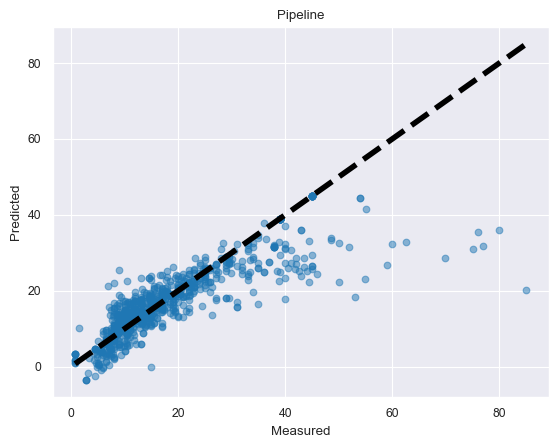

In [42]:
plot_predicted_vs_measured(svm, X_train, y_train, cv=5)

In [43]:
params_SVM = [{"svr__kernel": ["linear", "rbf"], "svr__C":  [0.1, 1, 10, 100], "svr__gamma": ["scale", "auto"]},
          {"svr__kernel": ["poly"], "svr__degree": range(1,5), "svr__C": [0.1, 1, 10, 100], "svr__epsilon": [.1, .5, 1 , 1.5]}]

svm_search = GridSearchCV(svm, params_SVM, scoring="neg_mean_squared_error", n_jobs=1, verbose=2).fit(X_train, y_train)
svm_results = pd.DataFrame(svm_search.cv_results_).sort_values("rank_test_score", ascending=True).head()
svm_results["mean_test_score"] = np.sqrt(-svm_results["mean_test_score"])
best_svm = svm_search.best_estimator_
display(svm_results)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV] END ...svr__C=0.1, svr__gamma=scale, svr__kernel=linear; total time=   0.0s
[CV] END ...svr__C=0.1, svr__gamma=scale, svr__kernel=linear; total time=   0.0s
[CV] END ...svr__C=0.1, svr__gamma=scale, svr__kernel=linear; total time=   0.0s
[CV] END ...svr__C=0.1, svr__gamma=scale, svr__kernel=linear; total time=   0.0s
[CV] END ...svr__C=0.1, svr__gamma=scale, svr__kernel=linear; total time=   0.0s
[CV] END ......svr__C=0.1, svr__gamma=scale, svr__kernel=rbf; total time=   0.0s
[CV] END ......svr__C=0.1, svr__gamma=scale, svr__kernel=rbf; total time=   0.0s
[CV] END ......svr__C=0.1, svr__gamma=scale, svr__kernel=rbf; total time=   0.0s
[CV] END ......svr__C=0.1, svr__gamma=scale, svr__kernel=rbf; total time=   0.0s
[CV] END ......svr__C=0.1, svr__gamma=scale, svr__kernel=rbf; total time=   0.0s
[CV] END ....svr__C=0.1, svr__gamma=auto, svr__kernel=linear; total time=   0.0s
[CV] END ....svr__C=0.1, svr__gamma=auto, svr__

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svr__C,param_svr__gamma,param_svr__kernel,param_svr__degree,param_svr__epsilon,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
13,0.059011,0.002127,0.012807,0.002157,100.0,scale,rbf,NaN,NaN,"{'svr__C': 100, 'svr__gamma': 'scale', 'svr__k...",-33.370372,-31.959313,-27.985382,-20.995105,-13.941061,5.064607,7.261307,1
69,0.076660,0.007023,0.011409,0.000796,100.0,NaN,poly,2.0,0.5,"{'svr__C': 100, 'svr__degree': 2, 'svr__epsilo...",-30.552959,-38.259661,-22.431495,-24.829651,-16.732970,5.153770,7.340776,2
70,0.065366,0.004093,0.010729,0.000389,100.0,NaN,poly,2.0,1.0,"{'svr__C': 100, 'svr__degree': 2, 'svr__epsilo...",-30.859398,-38.750825,-22.263685,-24.175846,-17.335048,5.164974,7.433369,3
68,0.098578,0.007227,0.011585,0.000792,100.0,NaN,poly,2.0,0.1,"{'svr__C': 100, 'svr__degree': 2, 'svr__epsilo...",-30.942390,-38.144076,-22.610574,-25.998549,-16.378641,5.178305,7.384371,4
71,0.057005,0.004526,0.010527,0.000445,100.0,NaN,poly,2.0,1.5,"{'svr__C': 100, 'svr__degree': 2, 'svr__epsilo...",-31.724162,-39.519867,-22.261256,-23.652119,-18.227300,5.203551,7.611300,5


In [44]:
df_clean[df_clean.precio>40]

,marca,modelo,precio,kilometraje,motor,region,año,combustible,transmision
13,M. BENZ,G,74.990000,94000,5.5,Metropolitana,2012,gasolina,automatico
45,BMW,X5,40.500000,70085,2.0,Metropolitana,2020,diesel,automatico
126,LAND ROVER,RANGE ROVER EVOQUE,44.990000,71000,2.0,Metropolitana,2021,gasolina,automatico
259,LAND ROVER,RANGE ROVER EVOQUE,44.990000,38500,2.0,Metropolitana,2022,gasolina,automatico
260,LAND ROVER,RANGE ROVER EVOQUE,44.990000,71000,2.0,Metropolitana,2021,gasolina,automatico
...,...,...,...,...,...,...,...,...,...
3434,FORD,EXPEDITION,62.490000,31281,3.5,Los Lagos,2024,gasolina,automatico
3467,FORD,F150 RAPTOR,45.900000,148700,3.5,Biobío,2019,gasolina,automatico
3624,LAND ROVER,EVOQUE,40.995750,33186,2.0,Metropolitana,2020,gasolina,automatico
3625,VOLVO,XC60,44.990420,4964,2.0,Metropolitana,2023,hibrido,automatico


Los modelos tienen problemas para predecir los precios de los autos más caros, ya que no hay suficientes datos para entrenarlos. Por lo tanto, se eliminan estos datos para mejorar la precisión del modelo.

In [45]:
df_clean = df_clean[df_clean.precio<=40]
X_train, X_test, y_train, y_test = train_test_split(df_clean[["marca", "modelo", "motor", "combustible", "kilometraje", "transmision", "region", "año"]], df_clean.precio, test_size=0.3, random_state=42) 


RMSE = 3.668


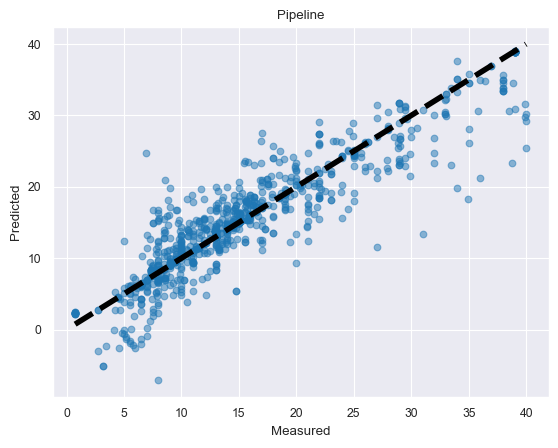

In [46]:
lin_reg.fit(X_train, y_train)
plot_predicted_vs_measured(lin_reg, X_train, y_train, cv=5)

In [47]:
params_SVM = [{"svr__kernel": ["linear", "rbf"], "svr__C":  [0.1, 1, 10, 100], "svr__gamma": ["scale", "auto"]},
          {"svr__kernel": ["poly"], "svr__degree": range(1,5), "svr__C": [0.1, 1, 10, 100], "svr__epsilon": [.1, .5, 1 , 1.5]}]

svm_search = GridSearchCV(svm, params_SVM, scoring="neg_mean_squared_error", n_jobs=-1, verbose=2).fit(X_train, y_train)
svm_results = pd.DataFrame(svm_search.cv_results_).sort_values("rank_test_score", ascending=True).head()
svm_results["mean_test_score"] = np.sqrt(-svm_results["mean_test_score"])
best_svm = svm_search.best_estimator_
display(svm_results)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svr__C,param_svr__gamma,param_svr__kernel,param_svr__degree,param_svr__epsilon,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
13,0.091014,0.017202,0.017800,0.002994,100.0,scale,rbf,NaN,NaN,"{'svr__C': 100, 'svr__gamma': 'scale', 'svr__k...",-6.890421,-9.130491,-9.406836,-8.040096,-8.358390,2.892274,0.888976,1
9,0.202953,0.136056,0.034409,0.021183,10.0,scale,rbf,NaN,NaN,"{'svr__C': 10, 'svr__gamma': 'scale', 'svr__ke...",-8.255809,-10.657605,-9.027988,-8.635035,-9.418073,3.032969,0.826127,2
70,0.100116,0.005238,0.017000,0.000633,100.0,NaN,poly,2.0,1.0,"{'svr__C': 100, 'svr__degree': 2, 'svr__epsilo...",-7.090462,-10.497658,-9.116512,-11.836916,-7.788552,3.044014,1.735785,3
69,0.146719,0.020414,0.022105,0.007658,100.0,NaN,poly,2.0,0.5,"{'svr__C': 100, 'svr__degree': 2, 'svr__epsilo...",-6.870804,-10.605480,-9.804485,-12.254722,-7.531569,3.068128,1.982584,4
71,0.089315,0.007989,0.016803,0.001166,100.0,NaN,poly,2.0,1.5,"{'svr__C': 100, 'svr__degree': 2, 'svr__epsilo...",-7.360888,-10.951185,-9.330384,-11.605827,-8.418087,3.087600,1.569077,5


In [48]:
params_SVM = [{"svr__kernel": ["rbf"], "svr__C":  [10, 100, 1000], "svr__gamma": ["scale"]}]

svm_search = GridSearchCV(svm, params_SVM, scoring="neg_mean_squared_error", n_jobs=-1, verbose=2).fit(X_train, y_train)
svm_results = pd.DataFrame(svm_search.cv_results_).sort_values("rank_test_score", ascending=True).head()
svm_results["mean_test_score"] = np.sqrt(-svm_results["mean_test_score"])
best_svm = svm_search.best_estimator_
display(svm_results)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svr__C,param_svr__gamma,param_svr__kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.094117,0.011898,0.023002,0.003035,100,scale,rbf,"{'svr__C': 100, 'svr__gamma': 'scale', 'svr__k...",-6.890421,-9.130491,-9.406836,-8.040096,-8.358390,2.892274,0.888976,1
0,0.168144,0.023170,0.024306,0.010201,10,scale,rbf,"{'svr__C': 10, 'svr__gamma': 'scale', 'svr__ke...",-8.255809,-10.657605,-9.027988,-8.635035,-9.418073,3.032969,0.826127,2
2,0.120028,0.009572,0.011903,0.001362,1000,scale,rbf,"{'svr__C': 1000, 'svr__gamma': 'scale', 'svr__...",-9.057048,-9.149959,-9.800142,-9.305606,-9.397910,3.056490,0.257846,3


# Random Forest

In [49]:
from sklearn.ensemble import RandomForestRegressor

rf = make_pipeline(preprocessing, RandomForestRegressor())
rf.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(func=<ufunc 'sqrt'>,
                                                                                       inverse_func=<ufunc 'square'>,
                                                                                       validate=True))]),
                                                  ['kilometraje']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='med...
                                                                   FunctionTransformer(func=<function neg_log at 0x000001F451353E20>,
                                                                                       inverse_func=<function inverse_neg_log at 0x000001F44CC49900>,
                                                                                       validate=True))]),
                                                  ['año']),
                                                 ('pipeline-4',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['marca', 'modelo',
                                                   'combustible', 'transmision',
                                                   'region'])])),
                ('randomforestregressor', RandomForestRegressor())])

In [50]:
print(f"RMSE = {root_mean_squared_error(y_train, rf.predict(X_train)):.3f}")

RMSE = 1.237


In [51]:
rf.score(X_train, y_train)

0.9795975701394615

RMSE = 3.339


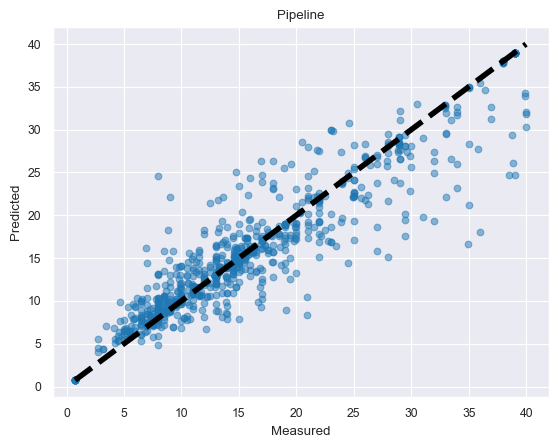

In [52]:
plot_predicted_vs_measured(rf, X_train, y_train, cv=10)

In [53]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

max_features = ['log2', 'sqrt', None]

max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

min_samples_split = [2, 5, 10]

min_samples_leaf = [1, 2, 4]

bootstrap = [True, False]

random_grid = {'randomforestregressor__n_estimators': n_estimators,
               'randomforestregressor__max_features': max_features,
               'randomforestregressor__max_depth': max_depth,
               'randomforestregressor__min_samples_split': min_samples_split,
               'randomforestregressor__min_samples_leaf': min_samples_leaf,
               'randomforestregressor__bootstrap': bootstrap,
               }

rf_search = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 5, verbose=1, random_state=42, n_jobs = 1, 
                              scoring="neg_mean_squared_error").fit(X_train, y_train)

rf_results = pd.DataFrame(rf_search.cv_results_).sort_values("rank_test_score", ascending=True).head()
rf_results["mean_test_score"] = np.sqrt(-rf_results["mean_test_score"])
best_forest = rf_search.best_estimator_

display(rf_results)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestregressor__n_estimators,param_randomforestregressor__min_samples_split,param_randomforestregressor__min_samples_leaf,param_randomforestregressor__max_features,param_randomforestregressor__max_depth,param_randomforestregressor__bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,6.593459,0.112920,0.103570,0.008608,1400,2,1,sqrt,80,False,"{'randomforestregressor__n_estimators': 1400, ...",-8.449953,-11.881435,-7.757883,-11.046034,-9.587083,3.121615,1.543228,1
8,8.782070,0.061104,0.090173,0.005317,1400,5,1,None,20,True,"{'randomforestregressor__n_estimators': 1400, ...",-9.596587,-11.649188,-10.358410,-15.397384,-13.053271,3.465684,2.061324,2
9,7.435875,0.468110,0.064303,0.002067,1000,10,1,None,80,False,"{'randomforestregressor__n_estimators': 1000, ...",-21.886971,-16.657722,-18.465891,-20.577811,-16.640955,4.341183,2.099616,3
5,0.905660,0.013587,0.042924,0.008328,600,2,2,sqrt,None,True,"{'randomforestregressor__n_estimators': 600, '...",-19.102174,-25.471070,-18.721841,-20.903629,-21.333843,4.594182,2.401926,4
4,3.009285,0.028753,0.037025,0.000707,600,10,4,None,20,False,"{'randomforestregressor__n_estimators': 600, '...",-21.716360,-23.026084,-19.255683,-25.870441,-23.295048,4.757386,2.159646,5


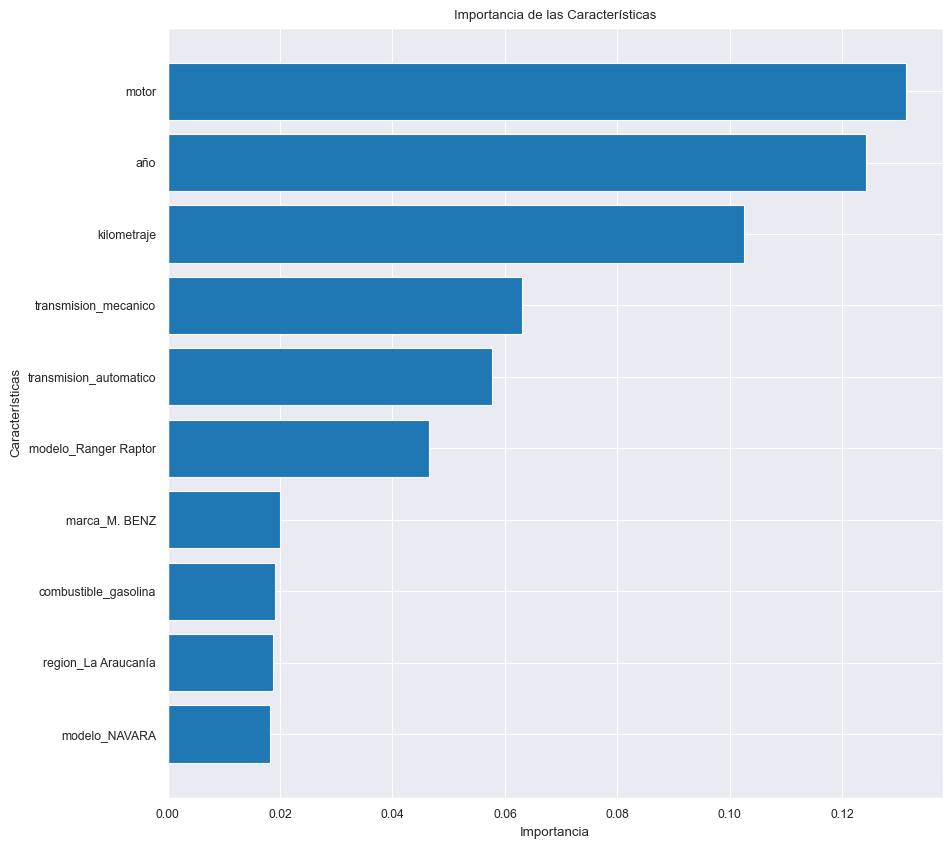

In [54]:


# Obtener las importancias de las características
importances = best_forest.named_steps['randomforestregressor'].feature_importances_

# Obtener las columnas numéricas
num_attribs = ["motor", "kilometraje", "año"]

# Acceder al OneHotEncoder para obtener los nombres de las columnas categóricas codificadas
encoder = best_forest.named_steps['columntransformer'].transformers_[3][1].named_steps['onehotencoder']

# Obtener los nombres codificados de las columnas categóricas
encoded_cat_columns = encoder.get_feature_names_out(['marca', 'modelo', 'combustible', 'transmision', 'region'])

# Unir todas las columnas (numéricas y categóricas codificadas)
all_columns = np.concatenate([num_attribs, encoded_cat_columns])

# Crear un DataFrame para organizar las importancias y las columnas
importances_df = pd.DataFrame({'Feature': all_columns, 'Importance': importances})

# Ordenar por importancia
importances_df = importances_df.sort_values(by='Importance', ascending=False).head(10)

# Graficar las importancias
plt.figure(figsize=(10, 10))
plt.barh(importances_df['Feature'], importances_df['Importance'])
plt.title('Importancia de las Características')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.gca().invert_yaxis()
plt.show()


In [55]:
from sklearn.ensemble import VotingRegressor

ensamble = VotingRegressor(estimators=[('svm', best_svm), ('rf', rf_search.best_estimator_)]).fit(X_train, y_train)


In [56]:
print(f"RMSE = {root_mean_squared_error(y_train, ensamble.predict(X_train)):.3f}")

RMSE = 0.234


RMSE = 2.848


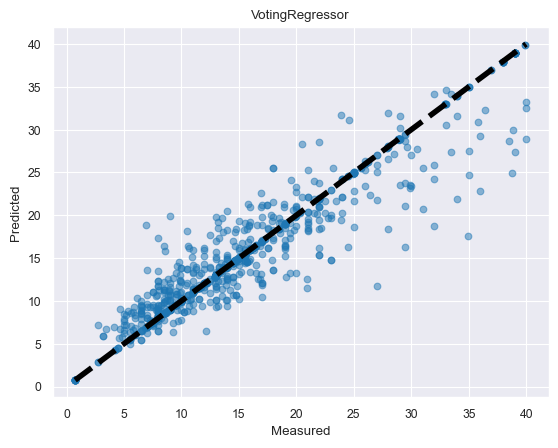

In [57]:
plot_predicted_vs_measured(ensamble, X_train, y_train, cv=5)

# Conjunto de test

RMSE = 3.511


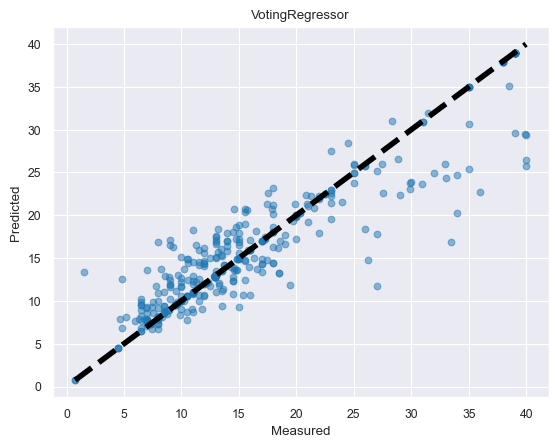

In [58]:
plot_predicted_vs_measured(ensamble, X_test, y_test, cv=5)

In [59]:
print(f"RMSE = {root_mean_squared_error(y_test, ensamble.predict(X_test)):.3f}")

RMSE = 3.121


# Serialización modelo

In [60]:
import joblib

X = pd.concat([X_train, X_test], axis=0)
y = pd.concat([y_train, y_test], axis=0)
final_model = ensamble = VotingRegressor(estimators=[('linear', best_lr), ('svm', best_svm), ('rf', rf_search.best_estimator_)]).fit(X, y)
joblib.dump(final_model, "model.pkl")


['model.pkl']